
# GPy doesn't allow for mean functions

GPy doesn't have real mean functions, but we can fake them. There are two ways of doing this

- fit a parametric mean, subtract it from the data, fit the GP to the noise left over, then your model is the GP plus the mean function

- use the linear or bias covariance functions built into GPy


Populating the interactive namespace from numpy and matplotlib


/Users/pmzrdw/Documents/Code/Emulation/MyGPy/GPy/GPy/util/linalg.py:48: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


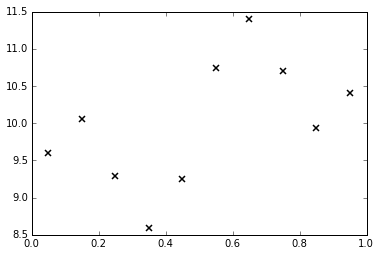

In [1]:
import GPy
import numpy as np 
import pylab as pb
import matplotlib.pyplot as plt
%pylab inline

X=np.linspace(0.05, 0.95, 10)[:,None]
Y = -np.cos(np.pi*X) + np.sin(4*np.pi*X)+10.
pb.figure()
pb.plot(X,Y,'kx',mew=1.5)


If we just fit a GP as usual there will be no mean term. For example, if we use a RBF covariance function:

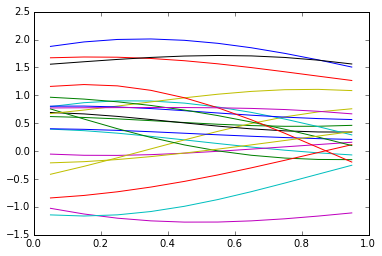

In [2]:
k = GPy.kern.RBF(1)

mu = np.zeros(X.size)
C = k.K(X,X)# covariance matrix

# Generate 20 sample path with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)


######

pb.figure() # open new plotting window 
for i in range(20):
    pb.plot(X[:],Z[i,:])



Optimization restart 1/10, f = 15.7930662677
Optimization restart 2/10, f = 15.7930662678
Optimization restart 3/10, f = 15.7930662679
Optimization restart 4/10, f = 15.7930662684
Optimization restart 5/10, f = 15.7930662677
Optimization restart 6/10, f = 15.7930662677
Optimization restart 7/10, f = 15.7930662682
Optimization restart 8/10, f = 15.7930662782
Optimization restart 9/10, f = 15.7930662802
Optimization restart 10/10, f = 15.7930662677

Name                 : GP regression
Log-likelihood       : -15.7930662677
Number of Parameters : 3
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance             |   100.052692045  |     +ve      |         |         
  rbf.lengthscale          |     8.817376157  |     +ve      |         |         
  Gaussian_noise.variance  |  0.591362027039  |     +ve      |         |         


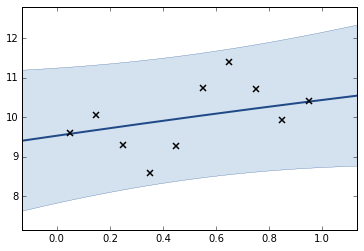

In [3]:
m = GPy.models.GPRegression(X, Y, k)
m.optimize_restarts(10)
m.plot()
print m

This hasn't worked well because we've ignored the non-zero mean.


### Option 1: subtract a fitted mean

The simplest way to fake a mean term is to calculate the mean of Y and subtract it from the data.

In [4]:
mu = Y.mean()
Yd = Y - mu
m = GPy.models.GPRegression(X, Yd, k)
m.optimize_restarts(10)

Xplot = np.linspace(-0.2,1.2,100)[:,None]
Yplot, Ysd = m.predict(Xplot)



Optimization restart 1/10, f = 4.40149296686
Optimization restart 2/10, f = 4.40149269379
Optimization restart 3/10, f = 11.9447340615
Optimization restart 4/10, f = 4.40149253256
Optimization restart 5/10, f = 4.40149251476
Optimization restart 6/10, f = 4.40150008287
Optimization restart 7/10, f = 4.40149250852
Optimization restart 8/10, f = 4.40152923055
Optimization restart 9/10, f = 4.40149251327
Optimization restart 10/10, f = 4.40149260066


 /Users/pmzrdw/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


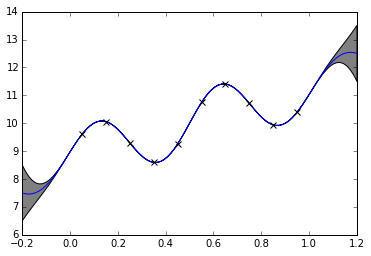

In [5]:
plt.subplots(1)
plt.plot(Xplot,Yplot+mu,'-',mew=1.5)
plt.plot(X, Y, 'kx', mew=1)
tmp = Yplot+mu-Ysd
tmp2 = Yplot+mu+Ysd


plt.fill_between(Xplot.reshape(100,), tmp.reshape(100,) , tmp2.reshape(100,),facecolor='grey',)


Or we can fit a linear trend by first estimating and then extracting a linear mean function.

In [6]:
Y.shape


(10, 1)

Optimization restart 1/10, f = 10.4474439096
Optimization restart 2/10, f = 10.4474506075
Optimization restart 3/10, f = 10.4474424782
Optimization restart 4/10, f = 3.84401560477
Optimization restart 5/10, f = 3.84401834985
Optimization restart 6/10, f = 10.4474451646
Optimization restart 7/10, f = 10.4474494715
Optimization restart 8/10, f = 10.4474427563
Optimization restart 9/10, f = 10.4474438438
Optimization restart 10/10, f = 3.84401567552


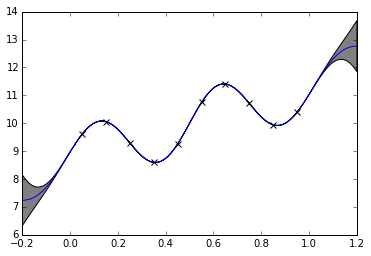

In [7]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)
Yfit = regr.predict(X)
Yd = Y - Yfit

m = GPy.models.GPRegression(X, Yd, k)
m.optimize_restarts(10)
YGPpred, Ysd = m.predict(Xplot)

Ylinregpred = regr.predict(Xplot)

Yplot = YGPpred+Ylinregpred

plt.subplots(1)
plt.plot(Xplot,Yplot,'-',mew=1.5)
plt.plot(X, Y, 'kx', mew=1)
tmp = Yplot-Ysd
tmp2 = Yplot+Ysd


plt.fill_between(Xplot.reshape(100,), tmp.reshape(100,) , tmp2.reshape(100,),facecolor='grey',)



### Option 2: use the bias covariance function

Now lets use the bias kernel to allow for a constant mean term. Let's begin by simulating from the prior again.

  add.             |  Value  |  Constraint  |  Prior  |  Tied to
  bias.variance    |    1.0  |     +ve      |         |         
  rbf.variance     |  100.0  |     +ve      |         |         
  rbf.lengthscale  |    1.0  |     +ve      |         |         


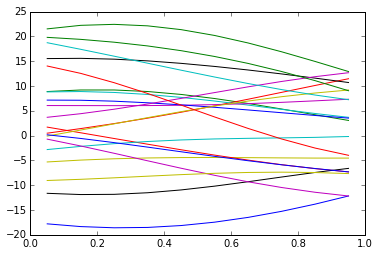

In [8]:
k = GPy.kern.Bias(1) + GPy.kern.RBF(1, 100)
print(k)
mu = np.zeros(X.size)
C = k.K(X,X) + np.eye(X.size)*0.00000001# covariance matrix

# Generate 20 sample path with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)

######

pb.figure() # open new plotting window 
for i in range(20):
    pb.plot(X[:],Z[i,:])


This has added a constant mean to each function. In the prior realisations, the mean is a random draw from a normal(0,100) distribution. If we now refit the model, it should work much better, as it will allow for a constant mean term.


Name                 : GP regression
Log-likelihood       : -6.75698857237
Number of Parameters : 4
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  add.bias.variance        |   97.1416616944  |     +ve      |         |         
  add.rbf.variance         |   8.31146324371  |     +ve      |         |         
  add.rbf.lengthscale      |  0.227164352215  |     +ve      |         |         
  Gaussian_noise.variance  |           1e-09  |    fixed     |         |         


 /Users/pmzrdw/Documents/Code/Emulation/MyGPy/GPy/GPy/likelihoods/gaussian.py:98: RuntimeWarning:invalid value encountered in sqrt


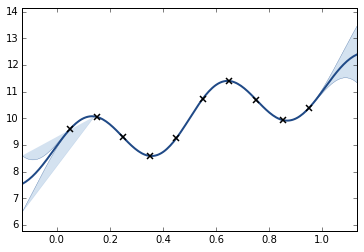

In [9]:
k = GPy.kern.Bias(1) + GPy.kern.RBF(1, 10)

m = GPy.models.GPRegression(X, Y, k)
m.Gaussian_noise.fix(0.000000001)
m.optimize()
m.plot()
print m

We can also allow for a linear trend by using the linear kernel. Again, we'll start by drawing realisations from the prior.

  add.              |  Value  |  Constraint  |  Prior  |  Tied to
  linear.variances  |  100.0  |     +ve      |         |         
  rbf.variance      |    1.0  |     +ve      |         |         
  rbf.lengthscale   |    1.0  |     +ve      |         |         


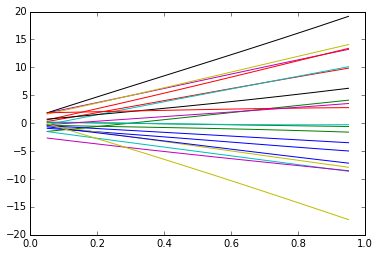

In [10]:
k = GPy.kern.Linear(1,100) + GPy.kern.RBF(1)
print(k)
mu = np.zeros(X.size)
C = k.K(X,X) + np.eye(X.size)*0.00000001# covariance matrix

# Generate 20 sample path with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)

######

pb.figure() # open new plotting window 
for i in range(20):
    pb.plot(X[:],Z[i,:])



Let's now fit the model with a linear term and a constant mean term.

Optimization restart 1/10, f = 6.69744063872
Optimization restart 2/10, f = 6.69744067812
Optimization restart 3/10, f = 6.69744063842
Optimization restart 4/10, f = 6.69805393419
Optimization restart 5/10, f = 6.69744063829
Optimization restart 6/10, f = 6.69744063895
Optimization restart 7/10, f = 6.69744063918
Optimization restart 8/10, f = 6.6974406389
Optimization restart 9/10, f = 6.69744063778
Optimization restart 10/10, f = 6.69744063778

Name                 : GP regression
Log-likelihood       : -6.69744063778
Number of Parameters : 5
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  add.bias.variance        |   80.3347151504  |     +ve      |         |         
  add.rbf.variance         |   6.43726214503  |     +ve      |         |         
  add.rbf.lengthscale      |  0.220962537534  |     +ve      |         |         
  add.linear.variances     |   8.07782322427  |     +ve      |         |         
  Gaussian_noise.variance  

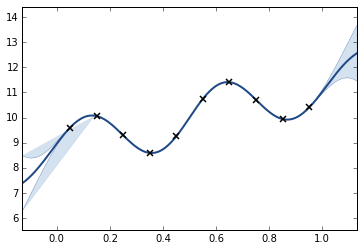

In [11]:
k = GPy.kern.Bias(1) + GPy.kern.RBF(1)+GPy.kern.Linear(1,100)

m = GPy.models.GPRegression(X, Y, k)
m.Gaussian_noise.fix(0.000000001)
m.optimize_restarts(10)
m.plot()
print m

In [12]:
Ysd.shape

(100, 1)

## Warning note

Note that a better approach is to include a linear mean function, specify Gaussian priors on the parameters, and then integrate out the uncertainty in the parameters. This takes the GP into account when estimating the mean function coefficients. This is a pain to implement with GPy however, so the above approaches are okay work arounds that shouldn't get you in too much trouble.